#### Лабораторная №3. Многослойная нейронная сеть

##### 1) Реализовать многослойную нейронную сеть с минимум 1 скрытым слоем (из 2+ нейронов) и выходным слоем с 1 нейроном для задачи XOR.

Для решения данной задачи будет достаточно использовать простейшую модель многослойной нейронной сети, выглядящей следующим образом: 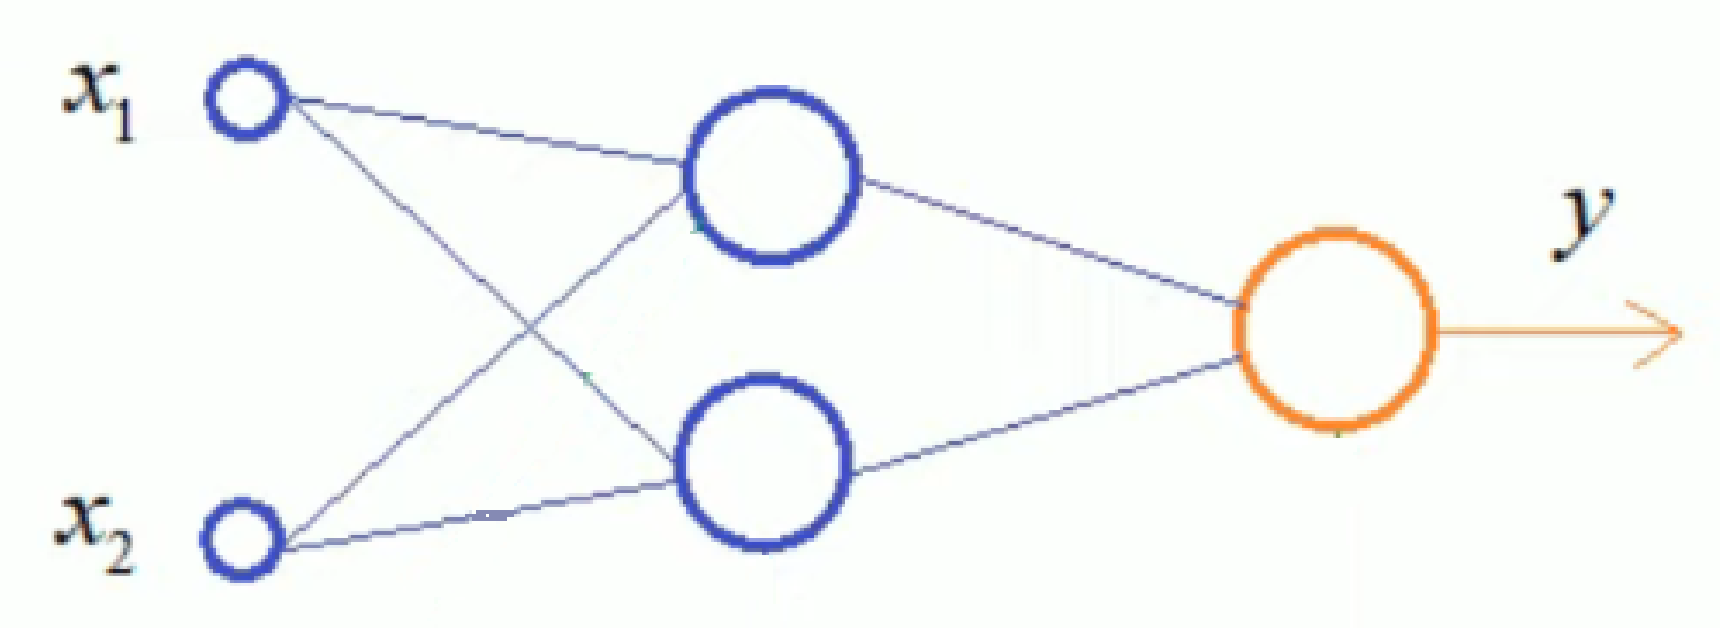
Используемая функция активации - сигмоида:

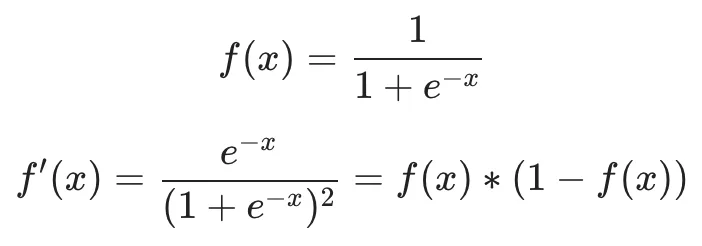

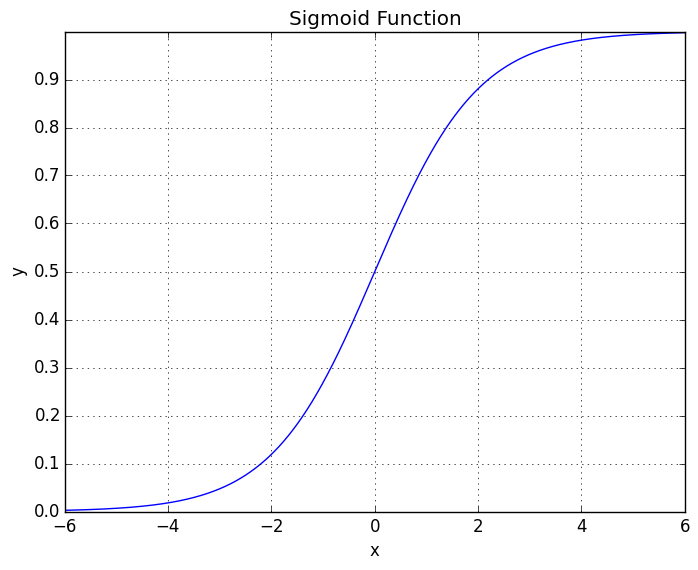

###### Код программы для XOR SGD ("Stochastic Gradient Descent" (Стохастический Градиентный Спуск))

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from tqdm import tqdm



np.random.seed(0)

def threshold(x):
  """Threshold activation function"""
  return (x >= 0.5).astype(int)

def threshold_der(x):
  """Threshold derivative activation function"""
  return 1

def sigmoid(x):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-x))

def sigmoid_der(x):
    """First derivative of sigmoid activation function"""
    return np.multiply(sigmoid(x), 1-sigmoid(x))

def tanh(x):
    """Tanh activation function"""
    return (1.0 - np.exp(-2*x))/(1.0 + np.exp(-2*x))

def tanh_derivative(x):
    """Tanh derivative activation function"""
    return (1 + x)*(1 - x)

def relu(x):
    """ReLU activation function"""
    return x * (x > 0)

def relu_der(x):
    """First derivative of the ReLU activation function"""
    return (x > 0).astype(int)

def mse(y_true,y_pred):
    """Calculate MSE"""
    return ((y_true - y_pred) ** 2).mean()

class MyNN:
    def __init__(self, arch):
        self.activation_func = tanh
        self.activation_der = tanh_derivative
        self.arch = arch
        self.layers_amount = len(arch)
        self.weights = []
        bias = 0

    def _init_weights(self):
        for layer in range(self.layers_amount - 1):
            # Random initialization with range of weight values [0,1) for sigmoid
            # w = np.random.rand(self.arch[layer], self.arch[layer+1])
            # For range (-1, 1)
            #w = 2 * np.random.rand(self.arch[layer], self.arch[layer+1]) - 1
            w = np.random.rand(self.arch[layer], self.arch[layer+1]) - 0.5
            self.weights.append(w)
    
    def _forward_prop(self, x):
        y = [x]
        # Move forward through layers
        for i in range(len(self.weights) - 1):
            temp = np.dot(y[i], self.weights[i])
            activation_func = self.activation_func(temp)
            y.append(activation_func)

        # This part'll be needed if i decide to add BIASEs, 
        # but probably it can be deleted with remove "-1" from for loop above range(len(self.weights) - 1)
        # Last layer
            
        temp = np.dot(y[-1], self.weights[-1])
        activation_func = self.activation_func(temp)
        y.append(activation_func)
        return y

    def _back_prop(self, y, target, lr, momentum):
        # Squared error
        o_error = 2*(target - y[-1]) *(-1)
        # Calc delta for last layer
        o_delta = o_error * self.activation_der(y[-1])
        delta_list = []
        delta_list.append(o_delta)
        for i in range(len(y) - 2, 0, -1):
        #    print(i)
        #    print(np.shape(y[i]))
        #    print(np.shape(self.weights[i].T))
        #    print(np.shape(delta_list[-1].dot((self.weights[i].T))))
        #    print(np.shape(delta_list[-1]))
        #    print()
           h_delta = self.activation_der(y[i]) * delta_list[-1].dot((self.weights[i].T))
           delta_list.append(h_delta)
    
        delta_list.reverse()

        # Calc gradients
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.arch[i])
            delta = delta_list[i].reshape(1, self.arch[i+1])
            gradient = layer.T.dot(delta)
            #print(i, gradient)
            self.weights[i] -= lr * gradient
        
        
    def train(self, data, labels, epoch_num, lr, momentum, mse_divider = 10):
        self._init_weights()
        mse_all_epoch = []
        print(np.shape(data), np.shape(labels))
        print("Start weights")
        print(self.weights)
        print()

        for epoch in tqdm(range(epoch_num),ncols=80, ascii=True, desc='Epoch'):
            for i in range(len(data)):
                y = self._forward_prop(data[i])
                self._back_prop(y, labels[i], lr, momentum)

            # Сохранение MSE для epoch % divider    
            if (epoch % mse_divider != 0): continue
            predictions = np.array([self.predict(s) for s in data])
            mse_epoch = mse(labels, predictions)
            mse_all_epoch.append(mse_epoch)
        
        # Построение графика для MSE
        plt.plot(range(1, epoch_num + 1, mse_divider), mse_all_epoch)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE over Epochs')
        plt.show()


    def predict(self, single_data):
        y = self._forward_prop(single_data)
        return y[-1]

##### 2)	Реализовать многослойную нейронную сеть с минимум 1 скрытым слоем (из 25+ нейронов) и одним выходным слоем из 10 нейронов, для распознавания рукописных цифр MNIST (каждый нейрон выходного слоя распознает только свою цифру, то есть один нейрон распознает только 0, второй 1, третий 2 и т.д.).

###### 2.1. Загрузка данных MNIST из KERAS

In [27]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Считывание данных
def load_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Train data
    data = {}

    # Train images
    temp_images = np.array(X_train, dtype='float32')
    data['images'] = np.array([np.ravel(image) for image in temp_images])/255
    
    # Train labels
    temp_labels = np.array(y_train, dtype='float32')
    data['labels'] = np.zeros((len(temp_labels), 10))
    for i, number in enumerate(temp_labels):
        data['labels'][i][int(number)] = 1
    print(np.shape(data['labels']))

    
    # Test data
    test_data = {}

    # Test images
    temp_images = np.array(X_test, dtype='float32')
    test_data['images'] = np.array([np.ravel(image) for image in temp_images])/255
    
    # Test labels
    test_data['labels'] = np.array(y_test, dtype='float32')


    print("Данные MNIST загружены")
    print("Тренировочная выборка: \n\tФормат изображений: ", np.shape(data['images']), "\n\tФормат ответов: ", np.shape(data['labels']))
    print("Тестовая выборка: \n\tФормат изображений: ", np.shape(test_data['images']), "\n\tФормат ответов: ", np.shape(test_data['labels']))
    return data, test_data

In [28]:
data, test_data = load_data()

(60000, 10)
Данные MNIST загружены
Тренировочная выборка: 
	Формат изображений:  (60000, 784) 
	Формат ответов:  (60000, 10)
Тестовая выборка: 
	Формат изображений:  (10000, 784) 
	Формат ответов:  (10000,)


###### 2.2. Обучение нейронной сети

In [ ]:
input_size = len(data['images'][0])
print(np.max(data['images'][0]))
nn_mnist = MyNN([784,32,10])
nn_mnist.train(data = data['images'], labels = data['labels'], epoch_num=10, lr=0.01, momentum=0, mse_divider=1)

In [116]:
import random
from keras.utils import to_categorical

image_count = np.zeros(10)
right_image_count = np.zeros(10)

for i, image in tqdm(enumerate(test_data['images']),ncols=80, ascii=True, desc='Images'):
    prediction_result = nn_mnist.predict(image)
    right_number = test_data['labels'][i]
    image_count[int(right_number)] += 1
    if (np.argmax(prediction_result) == right_number):
        right_image_count[int(right_number)] += 1

print("Total accuracy: ")

right = np.sum(right_image_count)
total = np.sum(image_count)
print(f' Image amout: {total}\n Right predictions: {right} = {right*100/total}%')

print("Detailed accuracy: ")
for i in range (10):
    print(f' {i}: {right_image_count[i]}/{image_count[i]} = {right_image_count[i]*100/image_count[i]}%')

Images: 10000it [00:00, 10565.65it/s]

Total accuracy: 
 Image amout: 10000.0
 Right predictions: 8764.0 = 87.64%
Detailed accuracy: 
 0: 946.0/980.0 = 96.53061224489795%
 1: 1104.0/1135.0 = 97.26872246696036%
 2: 861.0/1032.0 = 83.43023255813954%
 3: 832.0/1010.0 = 82.37623762376238%
 4: 875.0/982.0 = 89.10386965376782%
 5: 664.0/892.0 = 74.43946188340807%
 6: 831.0/958.0 = 86.74321503131524%
 7: 894.0/1028.0 = 86.96498054474708%
 8: 920.0/974.0 = 94.45585215605749%
 9: 837.0/1009.0 = 82.95341922695738%


Testing for one random img: 
Got random number 9226, image label is 6.0
Prediction is correct (6=6)


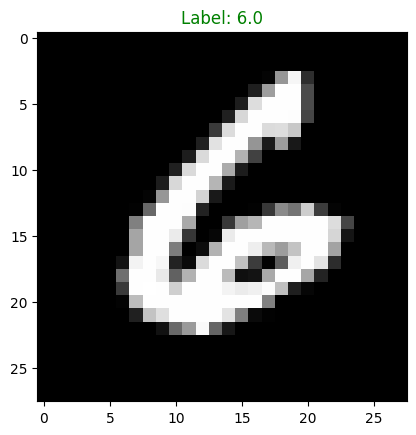

In [106]:
print("Testing for one random img: ")

random_number = random.randint(0, 10000)

test_img = test_data['images'][random_number]
test_answ = test_data['labels'][random_number]
prediction_result = nn_mnist.predict(test_img)

reshaped_img = np.reshape(test_img, (28, 28))
temp_label_color = ""
print(f"Got random number {random_number}, image label is {test_answ}")
if (np.argmax(prediction_result) == (test_answ)):
    print(f"Prediction is correct ({np.argmax(prediction_result)}={int(test_answ)})")
    temp_label_color = 'green'
else:
    print(f"Prediction is incorrect ({np.argmax(prediction_result)}!={int(test_answ)})")
    temp_label_color = 'red'

plt.imshow(reshaped_img, cmap='gray')
plt.title(f"Label: {test_answ}", color=temp_label_color)
plt.show()

##### 3) Реализовать многослойную нейронную сеть на Keras (Документация: https://keras.io/, Пример с рукописными цифрами MNIST: https://keras.io/examples/vision/mnist_convnet/). (разобраться в коде Keras и сравнить свою реализацию с реализацией Keras на одной топологии нейронной сети).

###### 3.1. Модель нейронной сети

In [47]:
import numpy as np
import keras
from keras import layers

input_shape = (768,1)
output_shape = 10
print(input_shape)
print(input_size)
model = keras.Sequential(
    [
        layers.Dense(32, input_dim=input_size, activation="sigmoid"),
        layers.Dense(output_shape, activation="sigmoid"),
    ]
)
model.summary()

(768, 1)
784


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 32)                │     25,120 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_23 (Dense)                │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

###### 3.2. Обучение модели

In [48]:
model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])
model.fit(data['images'], data["labels"], epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - accuracy: 0.4869 - loss: 1.9564 - val_accuracy: 0.8125 - val_loss: 1.1154
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step - accuracy: 0.7930 - loss: 1.0355 - val_accuracy: 0.8738 - val_loss: 0.7053
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.8458 - loss: 0.7209 - val_accuracy: 0.8920 - val_loss: 0.5373
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.8659 - loss: 0.5843 - val_accuracy: 0.8998 - val_loss: 0.4498
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.8790 - loss: 0.5021 - val_accuracy: 0.9075 - val_loss: 0.3964
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - accuracy: 0.8850 - loss: 0.4593 - val_accuracy: 0.9130 - val_loss: 0.3616
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.8930 - loss: 0.4189 - val_accuracy: 0.9185 - val_loss: 0.3363
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.8970 -

###### 3.3. Тестирование модели

In [86]:
test_labels = to_categorical(test_data['labels'], 10)
score = model.evaluate(test_data['images'], test_labels, verbose=0)


test_predictions = model.predict(test_data['images'])

print(test_data['labels'][0])
print(test_predictions[0])

image_count = np.zeros(10)
right_image_count = np.zeros(10)

for i, image in tqdm(enumerate(test_data['images']),ncols=80, ascii=True, desc='Images'):
    right_number = test_data['labels'][i]
    image_count[int(right_number)] += 1
    if (np.argmax(test_predictions[i]) == right_number):
         right_image_count[int(right_number)] += 1

print("Total accuracy: ")
print("Model evaluate test loss:", score[0])
print("Model evaluate test accuracy:", score[1])
right = np.sum(right_image_count)
total = np.sum(image_count)

print(f' Image amout: {total}\n Right predictions: {right} = {right*100/total}%')

print("Detailed accuracy: ")
for i in range (10):
    print(f' {i}: {right_image_count[i]}/{image_count[i]} = {right_image_count[i]*100/image_count[i]}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
7.0
[0.3192595  0.20369312 0.5651146  0.7898507  0.21930377 0.4773527
 0.01415893 0.9991973  0.28700453 0.8602603 ]


Images: 10000it [00:00, 281147.84it/s]

Total accuracy: 
Model evaluate test loss: 0.330318421125412
Model evaluate test accuracy: 0.9110999703407288
 Image amout: 10000.0
 Right predictions: 9111.0 = 91.11%
Detailed accuracy: 
 0: 953.0/980.0 = 97.24489795918367%
 1: 1107.0/1135.0 = 97.5330396475771%
 2: 917.0/1032.0 = 88.85658914728683%
 3: 909.0/1010.0 = 90.0%
 4: 909.0/982.0 = 92.56619144602851%
 5: 749.0/892.0 = 83.96860986547085%
 6: 892.0/958.0 = 93.1106471816284%
 7: 927.0/1028.0 = 90.1750972762646%
 8: 857.0/974.0 = 87.98767967145791%
 9: 891.0/1009.0 = 88.30525272547077%


Testing for one random img: 
Got random number 8329, image label is 4.0
Prediction is correct (4=4)


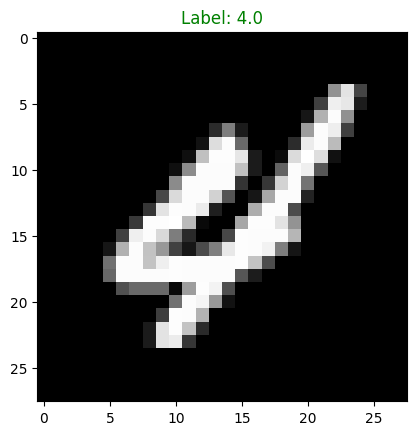

In [105]:
print("Testing for one random img: ")

random_number = random.randint(0, 10000)

test_img = test_data['images'][random_number]
test_answ = test_data['labels'][random_number]
prediction_result = test_predictions[random_number]

reshaped_img = np.reshape(test_img, (28, 28))
temp_label_color = ""
print(f"Got random number {random_number}, image label is {test_answ}")
if (np.argmax(prediction_result) == (test_answ)):
    print(f"Prediction is correct ({np.argmax(prediction_result)}={int(test_answ)})")
    temp_label_color = 'green'
else:
    print(f"Prediction is incorrect ({np.argmax(prediction_result)}!={int(test_answ)})")
    temp_label_color = 'red'

plt.imshow(reshaped_img, cmap='gray')
plt.title(f"Label: {test_answ}", color=temp_label_color)
plt.show()

##### 4) Нарисовать свою картинку цифры в Paint и подать в программу для распознавания (в свою нейронную сеть и в нейронку на Keras).

###### 4.1 Считывание и преобразование картинок

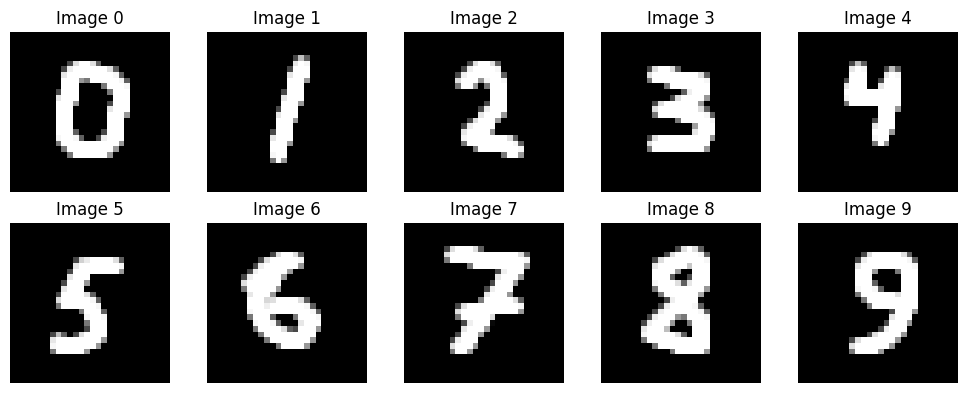

In [82]:
from matplotlib import pyplot as plt
from PIL import Image

img = []

for i in range(10):
    img_path = f'Source/{i}PNG.png'
    img.append(np.asarray(Image.open(img_path).convert('L'), dtype='float32')/255)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(img[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i}', color='black')

for i in range(10):
    axes[i].imshow(img[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i}', color='black')

plt.tight_layout()
plt.show()

###### 4.2. Определение картинок при помощи нейронных сетей

In [120]:
image_flattened = np.array(img).reshape(10, 784)

my_nn_result = []
keras_result = model.predict(image_flattened)
result_vector_my_nn = np.zeros(10)
result_vector_keras = np.zeros(10)


for i in range(10):
    my_nn_result.append(nn_mnist.predict(image_flattened[i]))
    if (np.argmax(my_nn_result[i]) == i):
        result_vector_my_nn[i] = 1
    if (np.argmax(keras_result[i]) == i):
        result_vector_keras[i] = 1

my_sum = np.sum(result_vector_my_nn)
keras_sum = np.sum(result_vector_keras)
print("Total accuracy: ")
print("\tMY NN: ")
print(f"\t\t{my_sum}/10 = {my_sum*100/10}%")
print("\tKeras: ")
print(f"\t\t{keras_sum}/10 = {keras_sum*100/10}%")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Total accuracy: 
	MY NN: 
		6.0/10 = 60.0%
	Keras: 
		7.0/10 = 70.0%


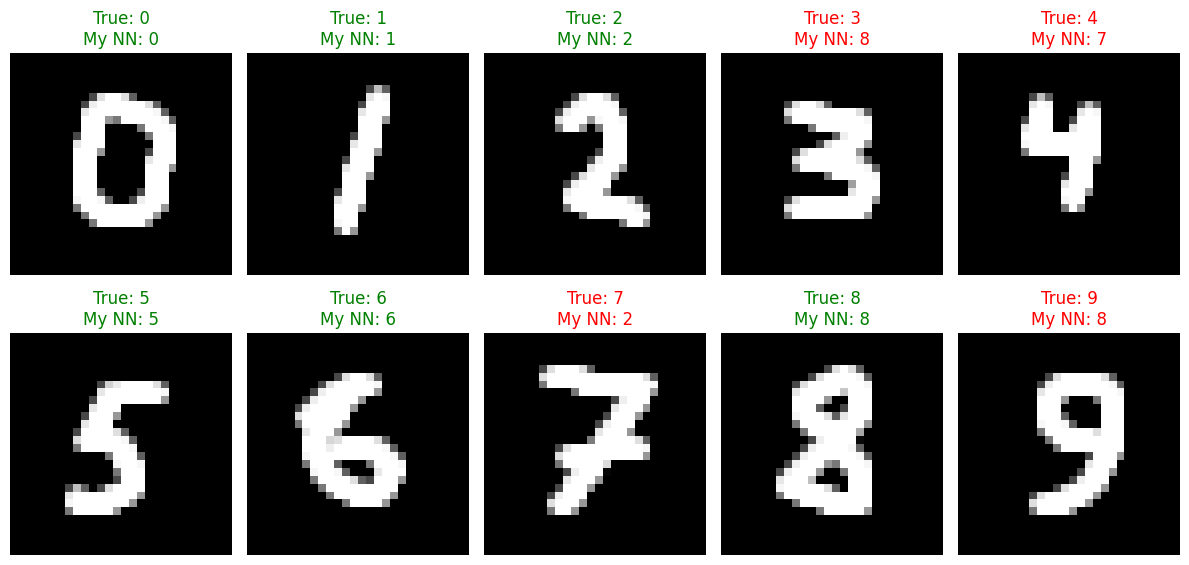

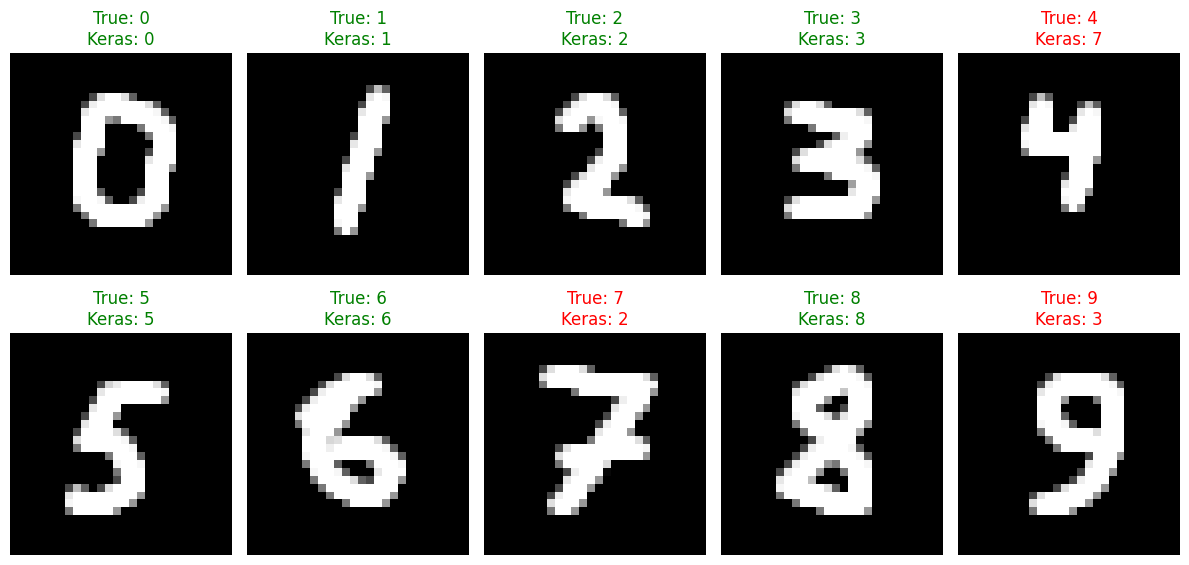

In [121]:

import matplotlib.pyplot as plt

def plot_images_with_titles(images, predictions, model_name):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')

        # Определение цвета заголовка в зависимости от правильности предсказания
        title_color = 'green' if i == np.argmax(predictions[i]) else 'red'

        axes[i].set_title(f"True: {i}\n{model_name}: {np.argmax(predictions[i])}", color=title_color)

    plt.tight_layout()
    plt.show()


plot_images_with_titles(img, my_nn_result, "My NN")
plot_images_with_titles(img, keras_result, "Keras")